In [16]:
!pip install -q rasterstats

In [17]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
import matplotlib
import ipyleaflet
import sys
import os
import dask_gateway
import planetary_computer
from rechunker import rechunk
sys.path.append('../sar_snowmelt_timing')
import s1_rtc_bs_utils
import contextily as ctx
import rioxarray as rxr
import pathlib
import glob
import re
import time
import fsspec
import rasterstats

In [2]:
cluster = dask_gateway.GatewayCluster(shutdown_on_close=False)
client = cluster.get_client()
cluster.adapt(minimum=10, maximum=400)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.9df94f0fed234ab48fcb2a3e6dcfc944/status


In [3]:
gj = '../input/shapefiles/western_us.geojson'
bbox_gdf = gpd.read_file(gj)

In [4]:
url = 'https://github.com/scottyhq/mgrs/raw/main/MGRS_LAND.parquet' # Scott created an MGRS parquet file here https://github.com/scottyhq/mgrs
with fsspec.open(url) as file:
    mgrs_gdf = gpd.read_parquet(file)

In [5]:
western_us = mgrs_gdf.clip(bbox_gdf)

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

bbox = western_us.total_bounds

search = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox,
    )

items = list(search.get_items())
items

stack_lc = stackstac.stack(items, bounds_latlon=bbox,resolution=0.00833333)#ts_ds.resolution or ts_ds.rio.resolution()[0]
worldcover = stack_lc.min(dim='time').squeeze()

In [7]:
classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]

In [8]:
worldcover = worldcover.where(worldcover.isin(classes)).rio.write_crs(rio.CRS.from_epsg(4326))

In [9]:
snowclass = rxr.open_rasterio('../input/SnowClass/SnowClass_GL_01km_30.0arcsec_2021_v01.0.nc').squeeze()

In [10]:
snowclass = snowclass.rio.reproject_match(worldcover).where(worldcover>0)

In [11]:
snow_present = snowclass.where(snowclass!=4).compute()

2023-01-27 01:20:19,893 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)


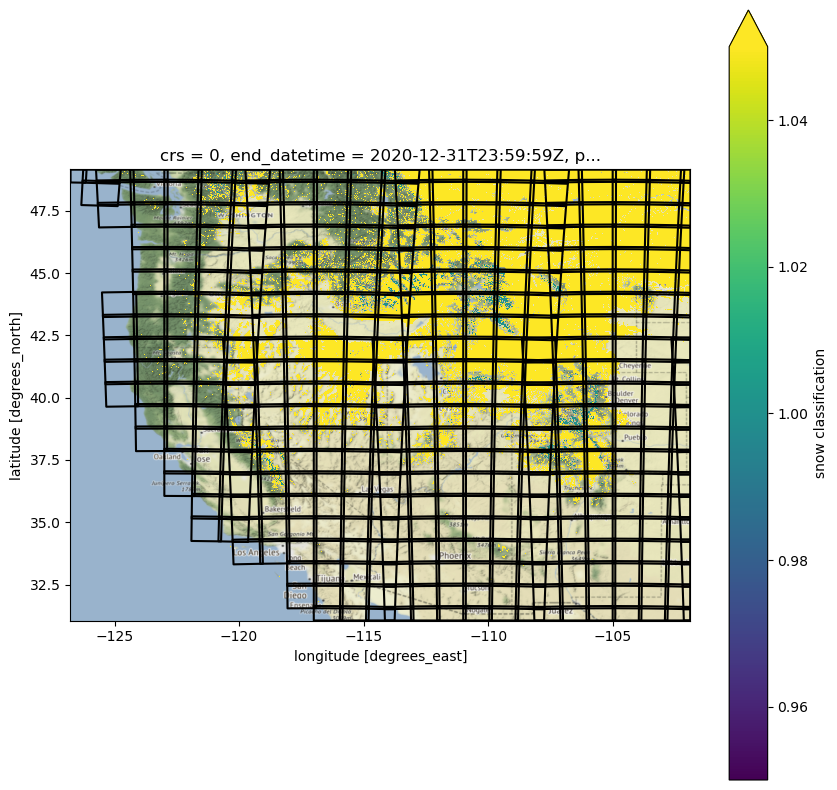

In [44]:
f,ax=plt.subplots(figsize=(10,10))
snow_present.plot(ax=ax,vmax=1)
western_us.boundary.plot(ax=ax,color='black')
ctx.add_basemap(ax=ax, crs=snow_present.rio.crs, source=ctx.providers.Stamen.Terrain,attribution=False)

In [13]:
western_us

,tile,geometry,epsg,utm_wkt,utm_bounds
791,11RNQ,"POLYGON ((-115.84241 31.63030, -115.84936 31.0...",32611,"POLYGON ((499980 3500040,499980 3390240,609780...","(499980.0, 3390240.0, 609780.0, 3500040.0)"
829,11SNR,"POLYGON ((-115.83099 32.53192, -115.84351 31.5...",32611,"POLYGON ((499980 3600000,499980 3490200,609780...","(499980.0, 3490200.0, 609780.0, 3600000.0)"
820,11SMR,"POLYGON ((-116.89606 32.53731, -116.89717 31.5...",32611,"POLYGON ((399960 3600000,399960 3490200,509760...","(399960.0, 3490200.0, 509760.0, 3600000.0)"
830,11SNS,"POLYGON ((-115.81904 33.43395, -115.83213 32.4...",32611,"POLYGON ((499980 3700020,499980 3590220,609780...","(499980.0, 3590220.0, 609780.0, 3700020.0)"
1093,12RYV,"POLYGON ((-107.73568 31.59381, -107.75400 31.0...",32612,"POLYGON ((699960 3500040,699960 3390240,809760...","(699960.0, 3390240.0, 809760.0, 3500040.0)"
...,...,...,...,...,...
1240,12UYV,"POLYGON ((-106.79902 48.58835, -108.28591 48.6...",32612,"POLYGON ((699960 5500020,699960 5390220,809760...","(699960.0, 5390220.0, 809760.0, 5500020.0)"
1567,13UFQ,"POLYGON ((-102.15252 48.62982, -103.64209 48.6...",32613,"POLYGON ((600000 5500020,600000 5390220,709800...","(600000.0, 5390220.0, 709800.0, 5500020.0)"
1540,13UCQ,"POLYGON ((-106.22487 48.65852, -107.71463 48.6...",32613,"POLYGON ((300000 5500020,300000 5390220,409800...","(300000.0, 5390220.0, 409800.0, 5500020.0)"
1558,13UEQ,"POLYGON ((-103.50933 48.65539, -105.00027 48.6...",32613,"POLYGON ((499980 5500020,499980 5390220,609780...","(499980.0, 5390220.0, 609780.0, 5500020.0)"


In [39]:
#rasterstats.zonal_stats(western_us,snow_present.values,affine=snow_present.rio.transform)

In [41]:
#pixels = []
#for i,row in western_us.iterrows():
#    pixels.append(snow_present.clip(row.geometry).count())

In [ ]:
western_us['bare_ground_and_snow_pixels'] = pixels